# Milestone 1 - Data Preprocessing and Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import networkx as nx
pd.options.mode.chained_assignment = None 

DATA_PATH = './data/'

## Part I : Data preprocessing

In [2]:
women_players_info = pd.read_csv(DATA_PATH + 'women_players_info.csv')
women_finals = pd.read_csv(DATA_PATH + 'women_finals.csv')

men_finals = pd.read_csv(DATA_PATH + 'men_finals.csv')
men_players_info = pd.read_csv(DATA_PATH + 'men_players_info.csv')
match_data = pd.read_csv(DATA_PATH + 'men_match_stats.csv')

print("Number of women's matches: " + str(len(women_finals)))
women_finals.sample(3)

Number of women's matches: 445


,Year,Tournament,Winner,Runner-up,Score
98,1996,French Open,Steffi Graf,Arantxa Sánchez Vicario,"6–3, 6–7(4), 10–8"
136,1986,US Open,Martina Navratilova,Helena Suková,"6–3, 6–2"
54,2007,French Open,Justine Henin,Ana Ivanovic,"6–1, 6–2"


In [3]:
print("Number of men's matches: " + str(len(men_finals)))
men_finals.sample(3)

Number of men's matches: 472


,Year,Tournament,Winner,Runner-up,Score
325,1935,French Championships,Fred Perry,Gottfried von Cramm,"6–3, 3–6, 6–1, 6–3"
62,2005,French Open,Rafael Nadal,Mariano Puerta,"6–7 (6), 6–3, 6–1, 7–5"
414,1906,U.S. National Championships,William A. Larned,Beals C. Wright,"6–3, 6–0, 6–4"


- There seems to be a problem converting year to numeric. This is because two Australian Opens took place in 1977 – one in early January, one in late December. However, the later one belonged to the 1978 Grand Slam season, so for simplicity, we will change the year.

In [4]:
all(men_finals.Year.str.isnumeric()) 

False

In [5]:
wrong_date = ~men_finals.Year.str.isnumeric()
men_finals[wrong_date]

,Year,Tournament,Winner,Runner-up,Score
171,1977 (2),Australian Open,Vitas Gerulaitis,John Lloyd,"6–3, 7–6, 5–7, 3–6, 6–2"
175,1977 (1),Australian Open,Roscoe Tanner,Guillermo Vilas,"6–3, 6–3, 6–3"


In [6]:
men_finals.at[wrong_date, 'Year'] = 1978
women_finals.at[wrong_date, 'Year'] = 1978

men_finals['Year'] = men_finals['Year'].apply(pd.to_numeric)
women_finals['Year'] = women_finals['Year'].apply(pd.to_numeric)

- Since we are considering records only from the Open Era which started from 1968, we discard records from previous years.

In [7]:
# drop data from before Open Era 
men = men_finals[(men_finals.Year > 1967) & (men_finals.Tournament != 'Australian Championships')]
women = women_finals[(women_finals.Year > 1967) & (women_finals.Tournament != 'Australian Championships')]

- Some of the tournament names are inconsistent in the dataset, for example *Wimbledon Championships (Open Era)* refers to *Wimbledon*.


In [8]:
# shorten name
men.loc[men.Tournament == 'Wimbledon Championships (Open Era)','Tournament'] = 'Wimbledon'
women.loc[women.Tournament == 'Wimbledon Championships (Open Era)','Tournament'] = 'Wimbledon'
women.loc[women.Tournament == 'U.S. Open','Tournament'] = 'US Open'

In [9]:
print("Number of men's matches (Open Era): " + str(len(men)))
print("Number of women's matches (Open Era): " + str(len(women)))

Number of men's matches (Open Era): 211
Number of women's matches (Open Era): 211


- Some of the values of the column **Died** are different from the others(for example there are values that are missing the place of death). Therefore we split this column into 3 columns: **Died_age**, **Died_date**, **Died_place** so that when using the players information in our data visualizations we can chose which details for the player to the display taking into account which are avaibale.

In [10]:
def create_death_columns(dataset):
    for i in range(dataset.shape[0]):
        curr_value = dataset.iloc[i]["Died"]
        if not pd.isnull(curr_value):
            split_values = dataset.iloc[i]["Died"].split(')')
            if(len(split_values)==3):
                if(split_values[0].split('(')[0] != "-"):
                    dataset.at[i,"Died_date"] = split_values[0].split('(')[0]
                if(split_values[1].split('(')[1]!="-"):
                    dataset.at[i,"Died_age"] = split_values[1].split(' ')[2]
                if(split_values[2]!=' '):
                    dataset.at[i,"Died_place"] = split_values[2]

In [11]:
create_death_columns(men_players_info)
men_players_info.drop('Died', inplace=True, axis=1)
men_players_info.sample(5)

,Name,Full name,Country (sports),Born,Height,Turned pro,Retired,Plays,Prize money,Int. Tennis HoF,...,Official website,Native name,Nationality,Batting,Cause of death,Listed height,Listed weight,Died_date,Died_age,Died_place
1,Pete Sampras,NaN,United States,1971-08-12,1.85 m,1988,"September 8, 2002 (last match)August 25, 2003 ...",Right-handed (one-handed backhand),"US$43,280,489 (5th all-time leader in earnings)",2007 (member page),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,Ernest Renshaw,Ernest James Renshaw,United Kingdom,1861-01-03,1.78 m,1879 (amateur tour),1897,Right-handed (one-handed backhand),NaN,1983 (member page),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 September 1899,38,"Waltham St. Lawrence, Berkshire, England"
80,Andy Roddick,Andrew Stephen Roddick,United States,1982-08-30,1.88 m,2000,"Singles: 2012 , Doubles: 2015",Right-handed (two-handed backhand),"US$20,640,030\n 20th all-time leader in earnings",2017 (member page),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,Arthur Gore,Arthur William Charles Wentworth Gore,United Kingdom,1969-01-02,NaN,1888 (amateur tour),1922,Right-handed (one-handed backhand),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 December 1928,60,"Kensington, England"
113,Ilie Năstase,NaN,Romania,1946-07-19,1.82 m,1969 (amateur tour from 1966),1985,Right-handed (one-handed backhand),"$2,076,761",1991 (member page),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
create_death_columns(women_players_info)
women_players_info.drop('Died', inplace=True, axis=1)
women_players_info.sample(5)

,Name,Full name,Country (sports),Residence,Born,Height,Turned pro,Retired,Plays,Coach,...,National team,Weight,ITF name,Batting,Bowling,Listed height,Listed weight,Died_date,Died_place,Died_age
153,Doris Hart,NaN,United States,NaN,1925-06-20,NaN,NaN,1955 (but played at the 1968 Wimbledon Champio...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"May 29, 2015","Coral Gables, Florida, U.S.",89
206,Kerry Reid,Kerry Melville Reid,Australia,NaN,1947-08-07,167 cm,NaN,1979,Right-handed (one-handed backhand),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Florence Sutton,Florence E. Sutton,United States,NaN,1883-09-02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"October 16, 1974",,91
200,Margaret Molesworth,Maud Margaret Mutch Molesworth,Australia,NaN,1894-10-18,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9 July 1985,"Sydney, New South Wales, Australia",90
44,Simone Mathieu,Simonne Passemard-Mathieu,France,NaN,1908-01-31,NaN,NaN,NaN,Right–handed (one-handed backhand),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7 January 1980,"Chatou, France",71


- In the *men_match_stats* dataset the names of the tournaments are not the same as in *men_finals*. For example in *men_match_stats* the name for the French Open Tournament is **Roland Garros** which is the venue, therefore we changed it to **French Open** as in *men_finals*. In addition the names include the year which we also remove from the name.

In [13]:
def change_name(name):
    if 'Roland Garros' in str(name) :
        return "French Open"
    elif 'Wimbledon' in str(name):
        return 'Wimbledon'
    elif 'Australian Open' in str(name):
        return'Australian Open'
    elif 'US Open' in str(name):
        return 'US Open'
    
def change_tournamentNames(dataset):
    dataset.Tournament= dataset.Tournament.apply(change_name)

In [14]:
change_tournamentNames(match_data)

In [15]:
match_data["Year"] = match_data.Date.apply(lambda date: date.split("-")[2])
match_data["Year"] = match_data["Year"].apply(pd.to_numeric)

In [16]:
match_data.sample(5)

,Tournament,Date,Participation,Winner,Runner-up,Final Score,Overview_Serve_Ace %_Winner,Overview_Serve_Ace %_Runner-up,Overview_Serve_Double Fault %_Winner,Overview_Serve_Double Fault %_Runner-up,...,Total_Points & Games_Games Won %_Winner,Total_Points & Games_Games Won %_Runner-up,Total_Dominance_Points Dominance_Winner,Total_Dominance_Games Dominance_Winner,Total_Dominance_Break Points Ratio_Winner,Total_Time_Point Time (seconds)_Winner,Total_Time_Game Time (minutes)_Winner,Total_Time_Set Time (minutes)_Winner,Total_Time_Match Time_Winner,Year
36,Wimbledon,24-06-2013,97.4%,Andy Murray,Novak Djokovic,6-4 7-5 6-4,9 / 105,4 / 105,2 / 105,4 / 105,...,19 / 32,13 / 32,0.82,0.57,0.75,54.0,5.91,63.0,3:09,2013
82,US Open,25-08-1997,93.0%,Patrick Rafter,Greg,6-3 6-2 4-6 7-5,7 / 123,9 / 136,6 / 123,4 / 136,...,23 / 39,16 / 39,0.80,0.48,0.94,33.6,3.72,36.3,2:25,1997
63,US Open,29-08-2016,91.5%,Stan Wawrinka,Novak Djokovic,6-7(1) 6-4 7-5 6-3,9 / 164,6 / 123,3 / 164,7 / 123,...,25 / 43,18 / 43,1.11,0.48,0.29,48.9,5.44,58.5,3:54,2016
95,Australian Open,13-01-2014,94.3%,Stan Wawrinka,Rafael Nadal,6-3 6-2 3-6 6-3,19 / 96,1 / 108,2 / 96,3 / 108,...,21 / 35,14 / 35,0.66,0.38,1.00,41.5,4.03,35.3,2:21,2014
3,French Open,29-05-2017,94.5%,Rafael Nadal,Stan Wawrinka,6-2 6-3 6-1,4 / 65,1 / 86,0 / 65,0 / 86,...,18 / 24,6 / 24,0.45,0.00,0.00,49.7,5.21,41.7,2:05,2017


## Part II: Exploratory Data Analysis

- In one of our visualizations we would like to display the number of wins and runner-ups over a specific period of time for each Grand Slam Tournament. The following plots show the data we would like to use and the idea behind our visualization. However these plots are hard to interpret since the information for all the users for the whole Open era is displayed at once. We intend to improve these plots by using an intercative visualization where the counts for each tournament will be separated and the user will be able to chose the time period.

In [17]:
def plot_tournaments(gender):
    for which in ['Winner', 'Runner-up']:
        df = gender.groupby([which, 'Tournament']).agg({which: 'count'}).rename(columns={which: 'count'}).unstack().fillna(0)
        df['total'] = df.sum(axis=1)
        
        df = df.sort_values(by=['total'], ascending=False)
        print(df.head())
        df = df.drop(columns=['total'])
        fig = df.plot(kind='bar', stacked=True, figsize=(15, 5))
        plt.ylabel('count')
        plt.legend(['Australian Open', 'French Open', 'US Open', 'Wimbledon'])
        plt.show()

                         count                               total
Tournament     Australian Open French Open US Open Wimbledon      
Winner                                                            
Rafael Nadal               1.0        13.0     4.0       2.0  20.0
Roger Federer              6.0         1.0     5.0       8.0  20.0
Novak Djokovic             9.0         1.0     3.0       5.0  18.0
Pete Sampras               2.0         0.0     5.0       7.0  14.0
Björn Borg                 0.0         6.0     0.0       5.0  11.0


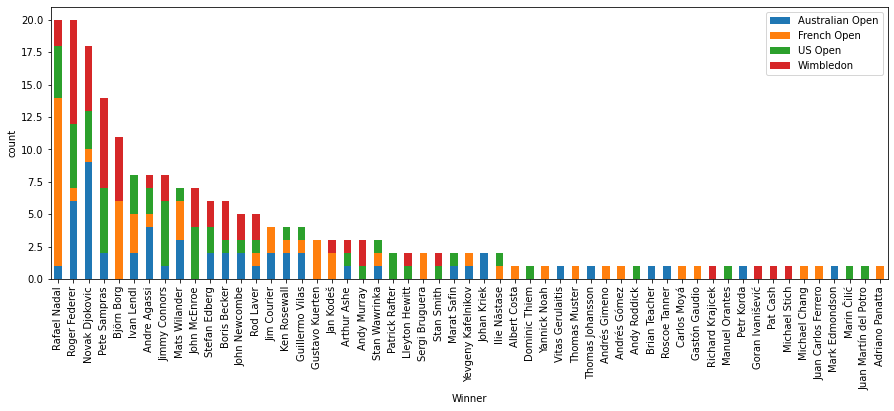

                         count                               total
Tournament     Australian Open French Open US Open Wimbledon      
Runner-up                                                         
Roger Federer              1.0         4.0     2.0       4.0  11.0
Ivan Lendl                 2.0         2.0     5.0       2.0  11.0
Novak Djokovic             0.0         4.0     5.0       1.0  10.0
Andy Murray                5.0         1.0     1.0       1.0   8.0
Rafael Nadal               4.0         0.0     1.0       3.0   8.0


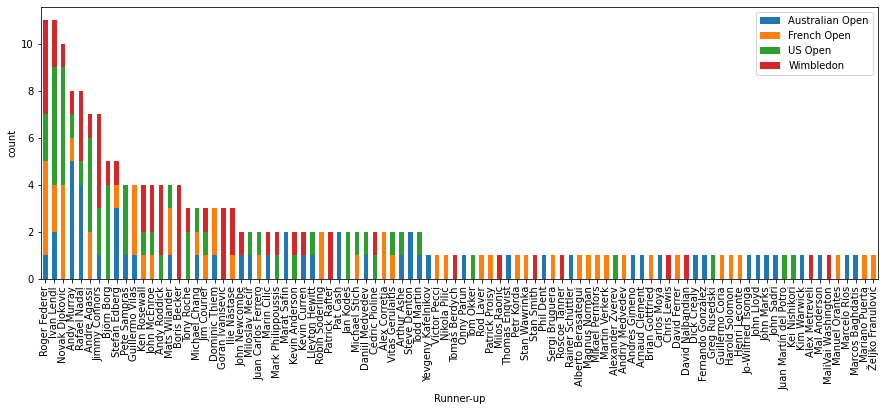

In [18]:
plot_tournaments(men)

                              count                               total
Tournament          Australian Open French Open US Open Wimbledon      
Winner                                                                 
Serena Williams                 7.0         3.0     6.0       7.0  23.0
Steffi Graf                     4.0         6.0     5.0       7.0  22.0
Chris Evert                     2.0         7.0     6.0       3.0  18.0
Martina Navratilova             3.0         2.0     4.0       9.0  18.0
Margaret Court                  4.0         3.0     3.0       1.0  11.0


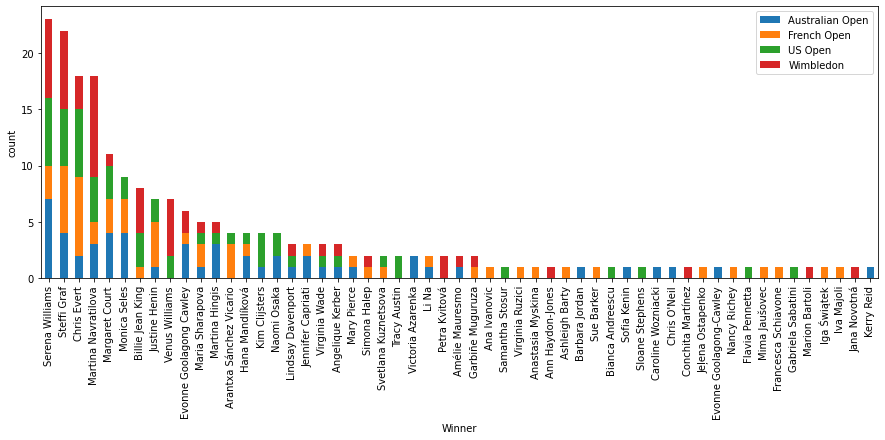

                                  count                               total
Tournament              Australian Open French Open US Open Wimbledon      
Runner-up                                                                  
Chris Evert                         4.0         2.0     3.0       7.0  16.0
Martina Navratilova                 3.0         4.0     4.0       3.0  14.0
Evonne Goolagong Cawley             3.0         1.0     4.0       3.0  11.0
Serena Williams                     1.0         1.0     4.0       4.0  10.0
Steffi Graf                         1.0         3.0     3.0       2.0   9.0


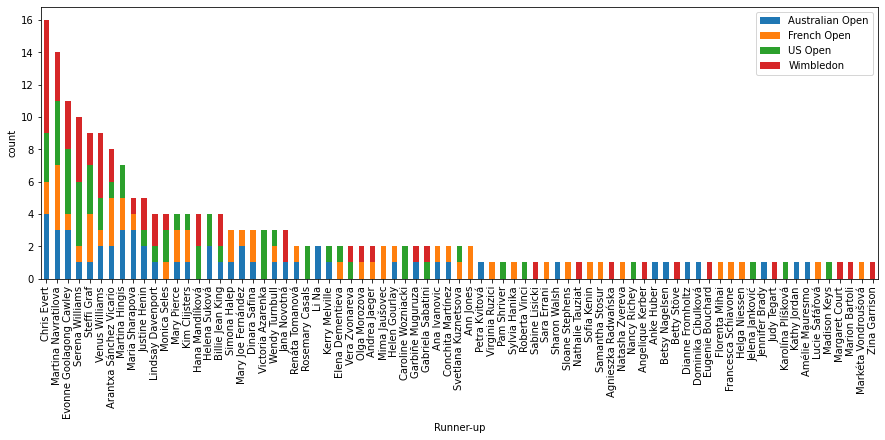

In [19]:
plot_tournaments(women)

- Some descriptive statistics about our dataset

In [20]:
winners_men = men['Winner'].unique().tolist()
rups_men = men['Runner-up'].unique().tolist()
men_players = set(winners_men + rups_men)
n_men = len(men_players)

print('Number of different Grand Slam winners (men): ' + str(len(winners_men)))
print('Number of different Grand Slam finalists (men): ' + str(n_men))

Number of different Grand Slam winners (men): 55
Number of different Grand Slam finalists (men): 106


In [21]:
winners_women = women['Winner'].unique().tolist()
rups_women = women['Runner-up'].unique().tolist()
women_players = set(winners_women + rups_women)
n_women = len(women_players)

print('Number of different Grand Slam winners (women): ' + str(len(winners_women)))
print('Number of different Grand Slam finalists (women): ' + str(n_women))

Number of different Grand Slam winners (women): 55
Number of different Grand Slam finalists (women): 94


In [22]:
men_players_data = men_players_info[men_players_info.Name.isin(men_players)]
assert(n_men == len(men_players_data))

women_players_data = women_players_info[women_players_info.Name.isin(women_players)]
assert(n_women == len(women_players_data))

- Our second visualization consists of a graph where the nodes are the players and the edges between the nodes show if those 2 players played in the Grand Slam finals. The following static graphs are again hard to read and the nodes and edges are not clear.

In [23]:
def plot_network(gender):
    matches = nx.Graph()

    pairs = []
    for idx, values in enumerate(np.sort(gender[['Winner','Runner-up']], axis=1)):
        pairs.append(tuple(values))
    pairs_counted = collections.Counter(pairs)

    for key in pairs_counted:
        matches.add_edge(key[0], key[1], weight=pairs_counted[key])

    edges = matches.edges()
    weights = [1.5*matches[u][v]['weight'] for u,v in edges]

    plt.figure(figsize=(40,40)) 
    nx.draw(matches, with_labels=True, alpha = 0.75, node_size=50, width=weights, font_size=20)

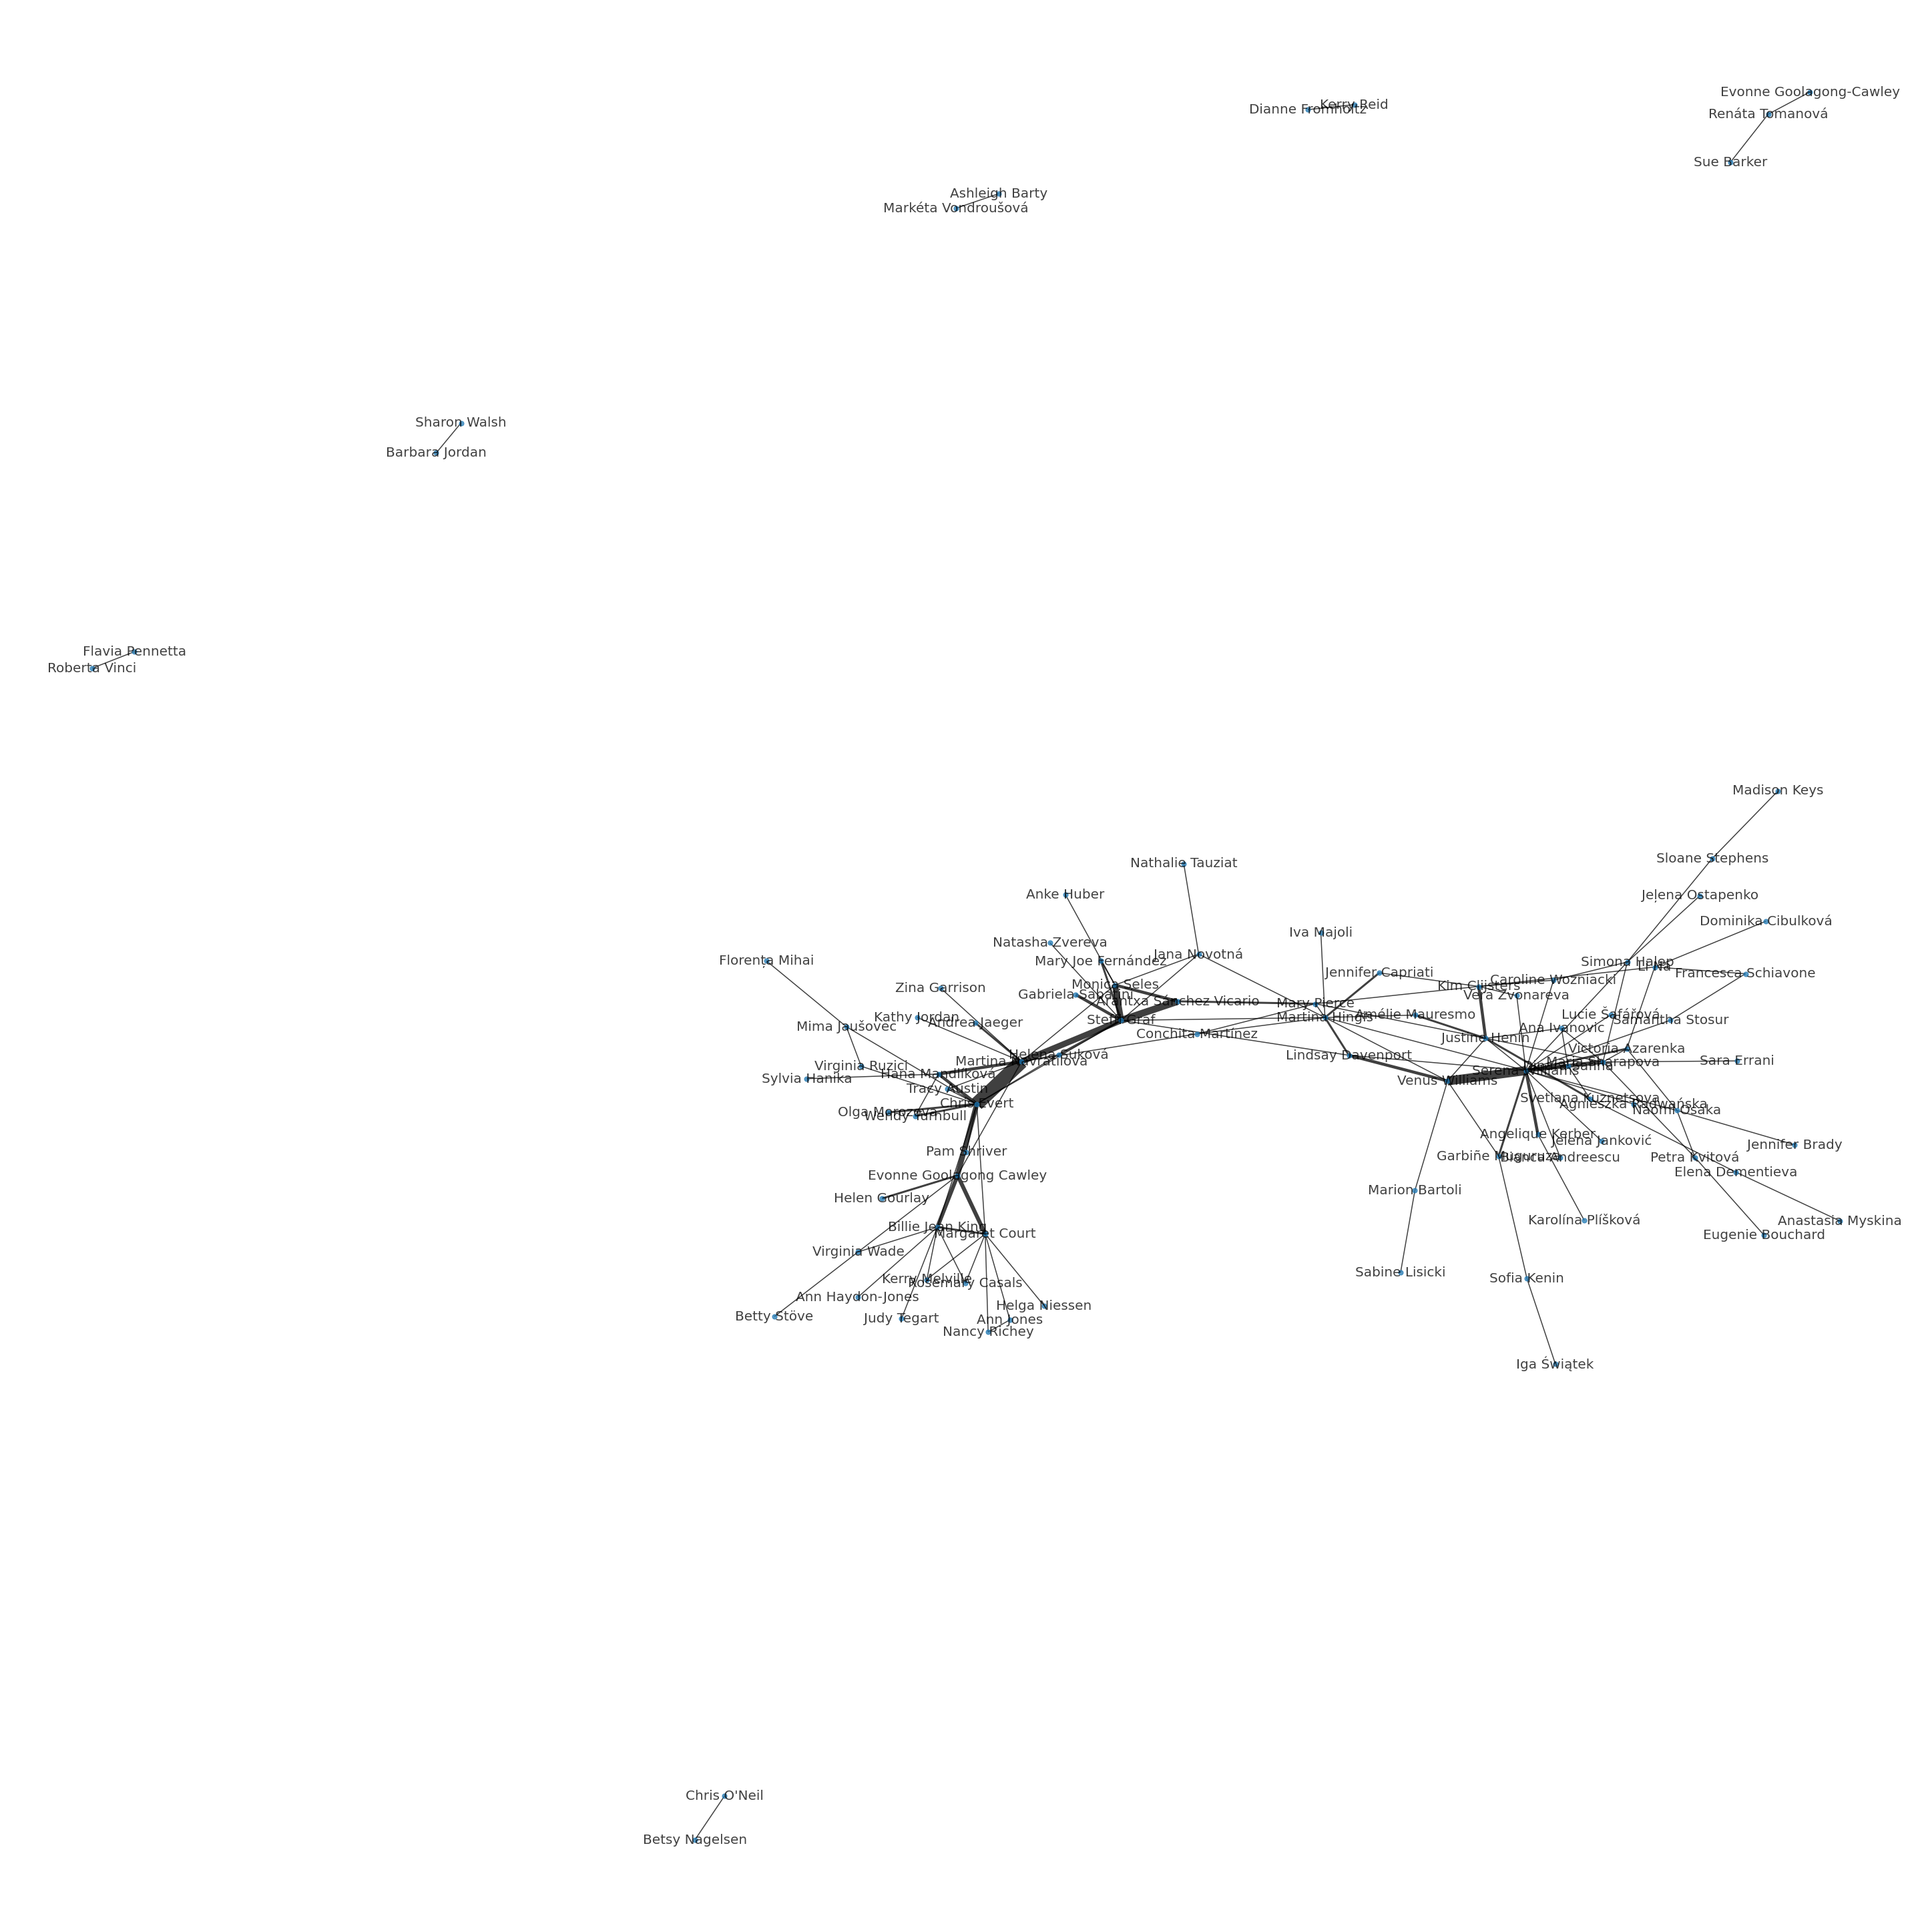

In [27]:
plot_network(women)
plt.savefig(DATA_PATH + "img/network_women.png")

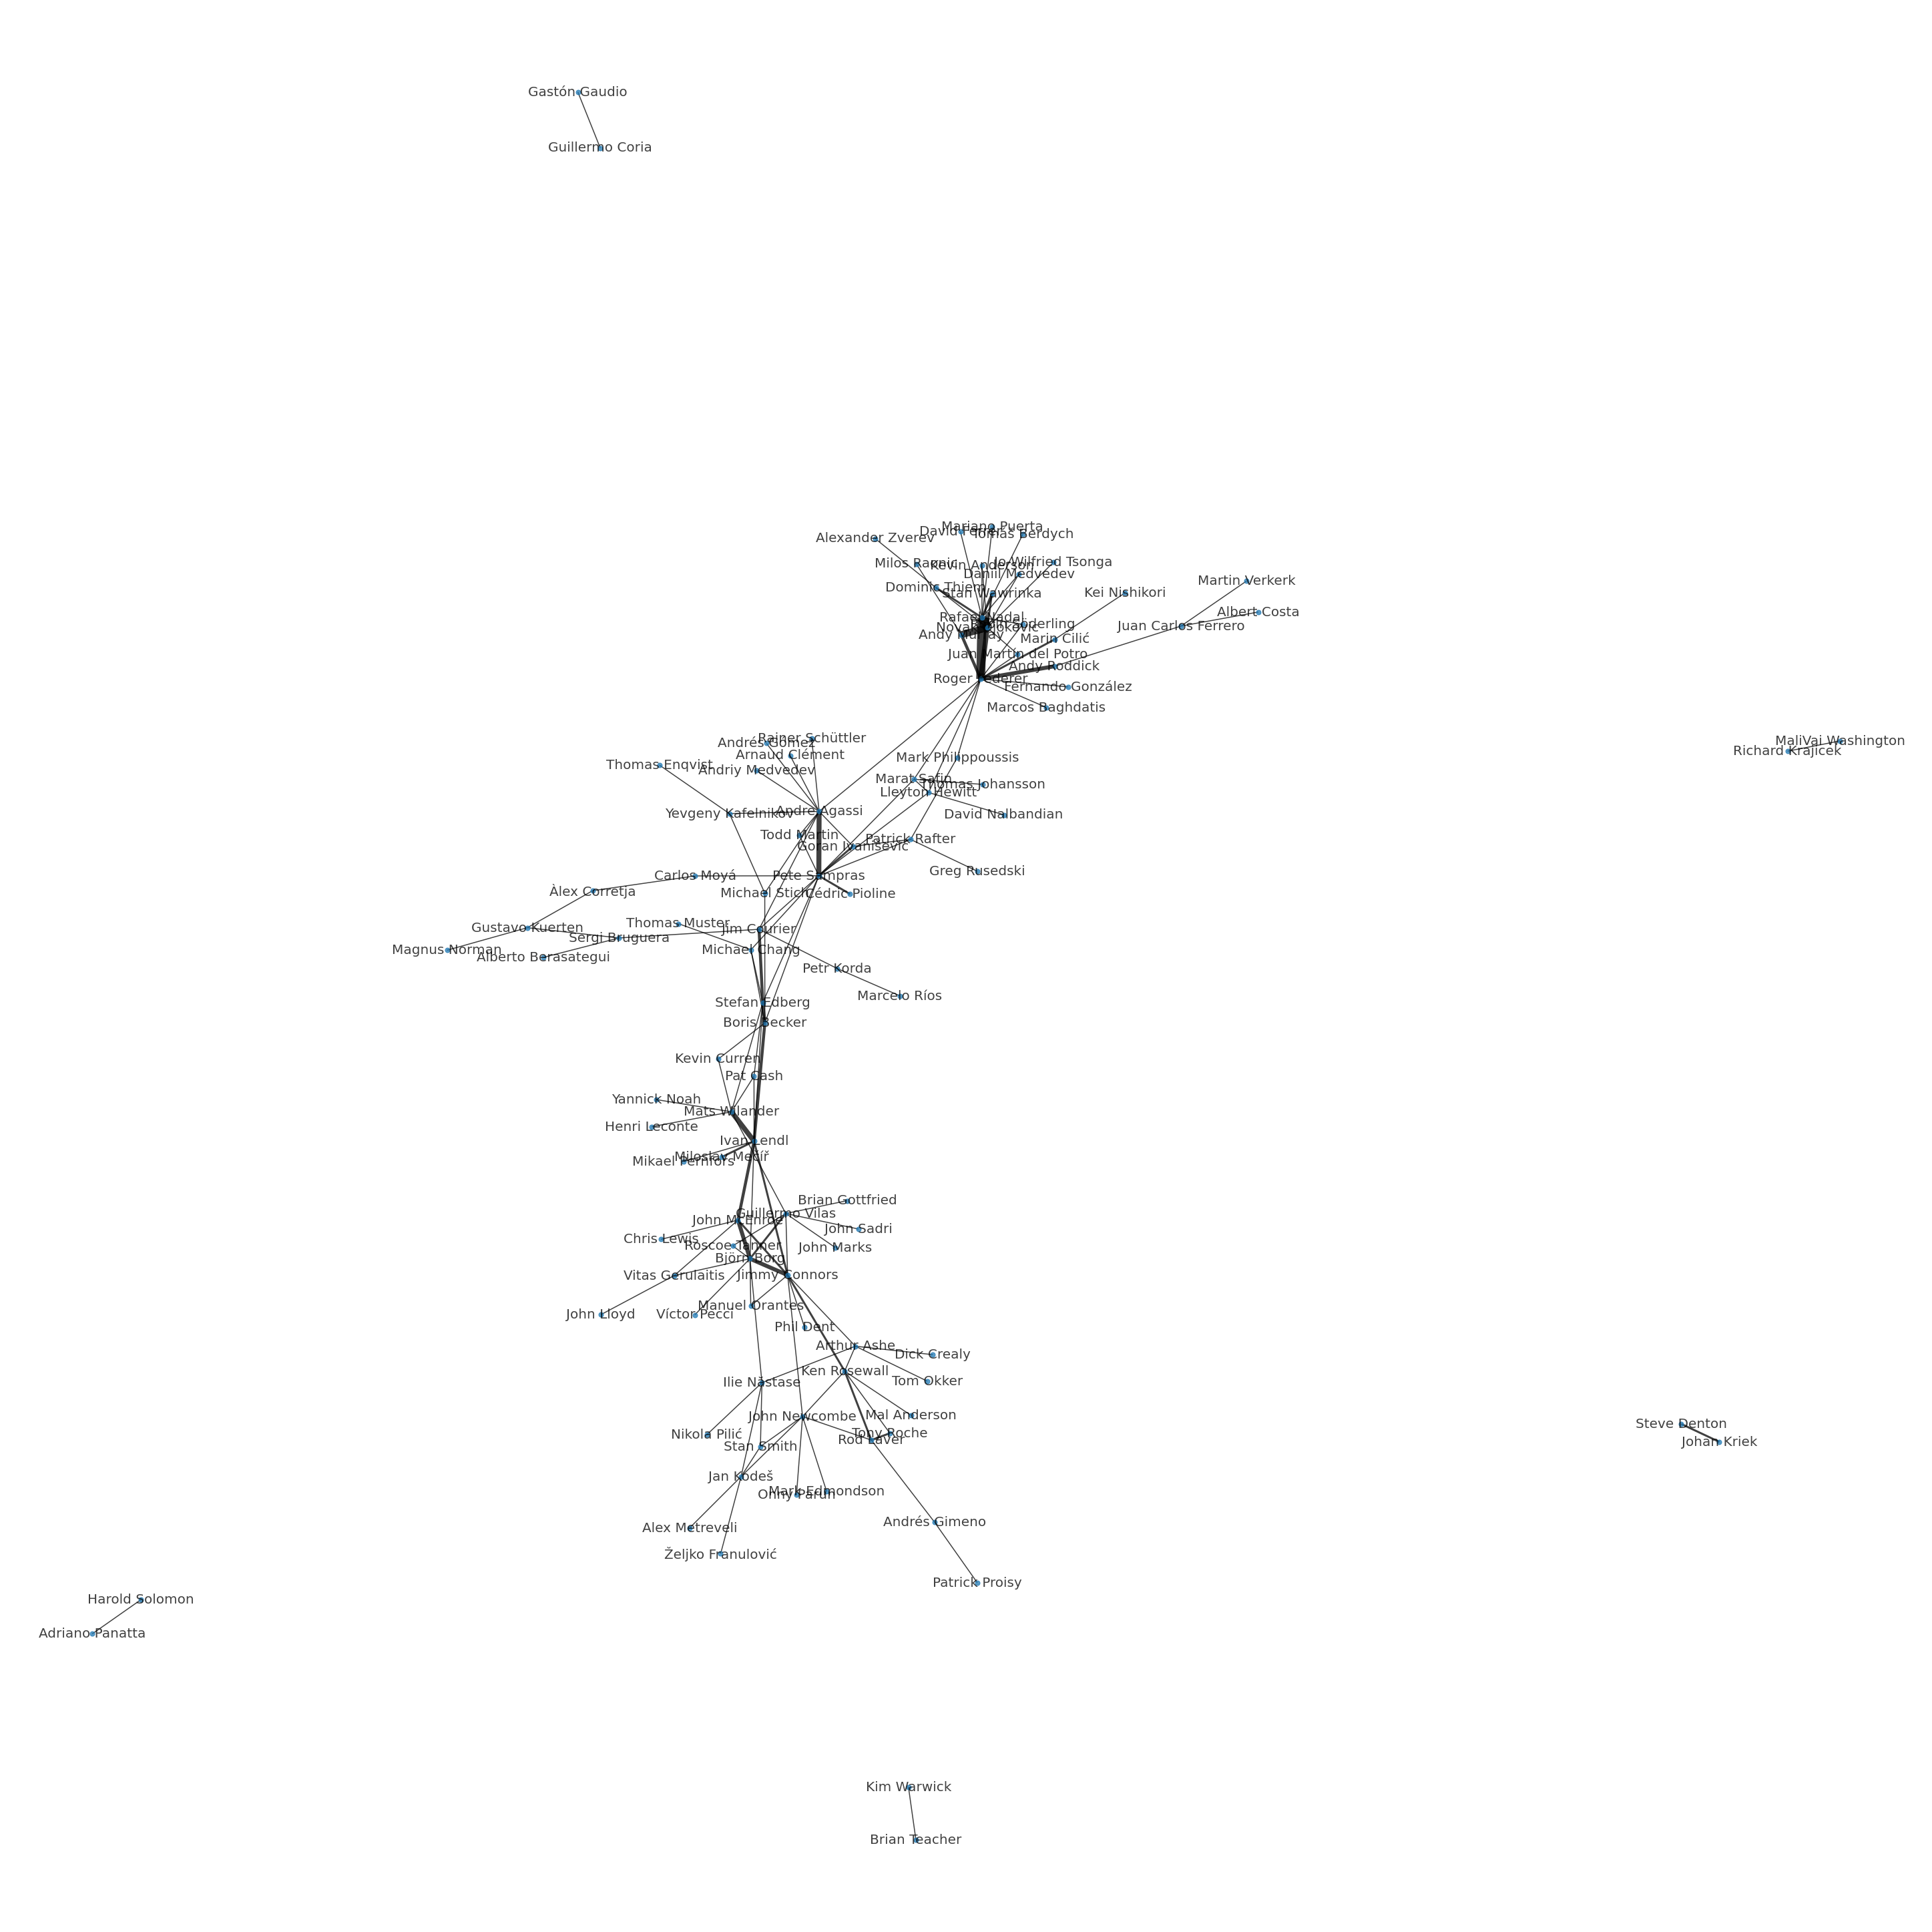

In [28]:
plot_network(men)
plt.savefig(DATA_PATH + "img/network_men.png")

- The edges of the graph will represent the matches between each two players that played against each other in the Grand Slam Finals. Therefore we intend, when the user selects an edge from the graph, to show the statistics for the matches between the 2 players. The statistics we intend to use are the following:

In [26]:
match_data.head()

,Tournament,Date,Participation,Winner,Runner-up,Final Score,Overview_Serve_Ace %_Winner,Overview_Serve_Ace %_Runner-up,Overview_Serve_Double Fault %_Winner,Overview_Serve_Double Fault %_Runner-up,...,Total_Points & Games_Games Won %_Winner,Total_Points & Games_Games Won %_Runner-up,Total_Dominance_Points Dominance_Winner,Total_Dominance_Games Dominance_Winner,Total_Dominance_Break Points Ratio_Winner,Total_Time_Point Time (seconds)_Winner,Total_Time_Game Time (minutes)_Winner,Total_Time_Set Time (minutes)_Winner,Total_Time_Match Time_Winner,Year
0,French Open,28-09-2020,91.4%,Rafael Nadal,Novak Djokovic,6-0 6-2 7-5,4 / 84,1 / 99,1 / 84,4 / 99,...,19 / 26,7 / 26,0.66,0.14,0.51,52.8,6.19,53.7,2:41,2020
1,French Open,27-05-2019,89.4%,Rafael Nadal,Dominic Thiem,6-3 5-7 6-1 6-1,3 / 106,7 / 92,0 / 106,1 / 92,...,23 / 35,12 / 35,0.66,0.27,0.62,54.8,5.17,45.3,3:01,2019
2,French Open,28-05-2018,86.5%,Rafael Nadal,Dominic Thiem,6-4 6-3 6-2,0 / 82,7 / 102,3 / 82,5 / 102,...,18 / 27,9 / 27,0.64,0.19,1.13,52.8,6.00,54.0,2:42,2018
3,French Open,29-05-2017,94.5%,Rafael Nadal,Stan Wawrinka,6-2 6-3 6-1,4 / 65,1 / 86,0 / 65,0 / 86,...,18 / 24,6 / 24,0.45,0.00,0.00,49.7,5.21,41.7,2:05,2017
4,French Open,23-05-2016,91.0%,Novak Djokovic,Andy Murray,3-6 6-1 6-2 6-4,4 / 110,5 / 109,3 / 110,3 / 109,...,21 / 34,13 / 34,0.77,0.43,0.60,50.1,5.38,45.8,3:03,2016
